In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from laspy.file import File
from pickle import dump, load

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

### Inputs

In [2]:
# Training Data parameters
scan_line_gap_break = 7000 # threshold over which scan_gap indicates a new scan line
min_pt_count = 1700 # in a scan line, otherwise line not used
max_pt_count = 2000 # in a scan line, otherwise line not used
seq_len = 25
num_scan_lines = 25 # to use as training set
val_split = 0.2

# LSTM Model parameters
hidden_size = 9 # hidden features
num_layers = 1 # Default is 1, 2 is a stacked LSTM
output_dim = 3 # x,y,z

# Training parameters
num_epochs = 100
learning_rate = 0.01

### Load the data

first_return_df has been processed in the following ways:  
* Removed outliers outside of [0.01,0.99] percentile range
* Normalized xyz values to [0,1]
* Mapped each point to a scan line index


In [3]:
first_return_df = pd.read_pickle("../../Data/parking_lot/first_returns_modified_164239.pkl")

In [4]:
first_return_df['abs_scan_angle_deg'] = abs(first_return_df['scan_angle_deg'])

In [5]:
# Note: x_scaled, y_scaled, and z_scaled MUST be the first 3 features
feature_list = [
    'x_scaled',
    'y_scaled',
    'z_scaled',
    'scan_line_idx',
    'scan_angle_deg',
    'abs_scan_angle_deg'
]

#### 2) Extract tensor of scan lines

In [6]:
# Number of points per scan line
scan_line_pt_count = first_return_df.groupby('scan_line_idx').count()['gps_time']

# Identify the indices for points at end of scan lines
scan_break_idx = first_return_df[(first_return_df['scan_gap']>scan_line_gap_break)].index

In [7]:
# Create Tensor
line_count = ((scan_line_pt_count>min_pt_count)&(scan_line_pt_count<max_pt_count)).sum()
scan_line_tensor = torch.randn([line_count,min_pt_count,len(feature_list)])

# Collect the scan lines longer than min_pt_count
# For each, collect the first min_pt_count points
i=0
for line,count in enumerate(scan_line_pt_count):
    if (count>min_pt_count)&(count<max_pt_count):
        try:
            line_idx = scan_break_idx[line-1]
            scan_line_tensor[i,:,:] = torch.Tensor(first_return_df.iloc\
                                      [line_idx:line_idx+min_pt_count][feature_list].values)
            i+=1
        except RuntimeError:
            print("line: ",line)
            print("line_idx: ",line_idx)

Note: Setting all features to [0,1] overvalues the z coordinate in MSE Loss.

In [8]:
def min_max_tensor(tensor):
    # Function takes a 3-D tensor, performs minmax scaling to [0,1] along the third dimension.
    # First 2 dimensions are flattened
    a,b,c = tensor.shape
    # Flatten first two dimensions
    flat_tensor = tensor.view(-1,c)
    sc =  MinMaxScaler()
    flat_norm_tensor = sc.fit_transform(flat_tensor)
    # Reshape to original
    output = flat_norm_tensor.reshape([a,b,c])
    return torch.Tensor(output), sc

In [9]:
scan_line_tensor_norm, sc = min_max_tensor(scan_line_tensor)

#### 3) Generate the data
First, naively: Concatenate all the sequences from all scan lines  
To Do: Track scan line, scan angle, decide where to incorporate these features.

In [10]:
def sliding_windows(data, seq_length, line_num, x, y):
    for i in range(len(data)-seq_length):
        # Index considers previous lines
        idx = i+line_num*(min_pt_count-seq_length)
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length,:3] # Assumes xyz are the first 3 features in scan_line_tensor
        x[idx,:,:] = _x
        y[idx,:,:] = _y

    return x,y

def generate_samples(data,min_pt_count,seq_len,num_scan_lines,val_split,starting_line=1000):
    '''
    Function generates training and validation samples for predicting the next point in the sequence.
    Inputs:
        data: 3-Tensor with dimensions: i) the number of viable scan lines in the flight pass, 
                                        ii) the minimum number of points in the scan line,
                                        iii) 3 (xyz, or feature count)
    
    '''
    # Create generic x and y tensors
    x = torch.ones([(min_pt_count-seq_len)*num_scan_lines,seq_len,len(feature_list)]) 
    y = torch.ones([(min_pt_count-seq_len)*num_scan_lines,1,3])
    i=0
    # Cycle through the number of scan lines requested, starting somewhere in the middle
    for line_idx in range(starting_line,starting_line+num_scan_lines):
        x,y = sliding_windows(data[line_idx,:,:],seq_len,line_idx-starting_line, x, y)
    x_train,y_train,x_val,y_val = train_val_split(x,y,val_split)
    return x_train,y_train,x_val,y_val

def train_val_split(x,y,val_split):   
    # Training/Validation split
    # For now, we'll do the last part of the dataset as validation...shouldn't matter?
    train_val_split_idx = int(x.shape[0]*(1-val_split))
    x_train = x[:train_val_split_idx,:,:]
    x_val = x[train_val_split_idx:,:,:]
    y_train = y[:train_val_split_idx,:,:]
    y_val = y[train_val_split_idx:,:,:]
    
    return x_train,y_train,x_val,y_val

In [11]:
x_train,y_train,x_val,y_val = generate_samples(scan_line_tensor_norm,min_pt_count,seq_len,num_scan_lines,val_split)

### 2: Train the model  
Borrowing a lot of code from here: https://github.com/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

#### 1) Define the model

In [12]:
class LSTM(nn.Module):

    def __init__(self, output_dim, input_size, hidden_size, num_layers, seq_len):
        super(LSTM, self).__init__()
        # output_dim = 3: X,Y,Z
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        # inputs_size = 3: X,Y,Z (could be larger in the future if we add features here)
        self.input_size = input_size
        
        # Not sure what to do here, larger than input size?
        self.hidden_size = hidden_size
        # Passes from above
        self.seq_len = seq_len
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        # In case multiple LSTM layers are used, this predicts using only the last layer
        h_out = h_out.view(num_layers,-1, self.hidden_size)
        out = self.fc(h_out[-1,:,:])
        
        return out

In [13]:
# Define a loss function that weights the loss according to coordinate ranges (xmax-xmin, ymax-ymin, zmax-zmin)
def weighted_MSELoss(pred,true,sc):
    '''Assumes that x,y,z are the first 3 features in sc scaler'''
    ranges = torch.Tensor(sc.data_max_[:3]-sc.data_min_[:3])
    raw_loss = torch.zeros(3,dtype=float)
    crit = torch.nn.MSELoss()
    for i in range(3):
        raw_loss[i] = crit(pred[:,:,i], true[:,:,i])
    return (ranges * raw_loss).sum()

In [14]:
def calculate_loss(lstm,x_train,y_train,x_val,y_val):
    # Training loss
    y_train_pred = lstm(x_train).detach()
    train_loss = weighted_MSELoss(y_train_pred.unsqueeze(1), y_train,sc)
    # Validation loss
    y_val_pred = lstm(x_val).detach()
    val_loss = weighted_MSELoss(y_val_pred.unsqueeze(1), y_val,sc)
    print("Training Loss: {:.4f}\nValidation Loss: {:.4f}".format(train_loss,val_loss))
    return train_loss, val_loss

#### 2) Train the model

******************************
Epoch: 0, loss: 1934.04015

Training Loss: 1576.6613
Validation Loss: 1563.9497
******************************
Epoch: 20, loss: 99.95342

Training Loss: 87.6301
Validation Loss: 86.1524
******************************
Epoch: 40, loss: 61.27561

Training Loss: 59.3486
Validation Loss: 59.7484
******************************
Epoch: 60, loss: 33.17627

Training Loss: 31.1842
Validation Loss: 30.8095
******************************
Epoch: 80, loss: 4.20551

Training Loss: 4.1515
Validation Loss: 4.1248


Text(0, 0.5, 'Weighted MSE')

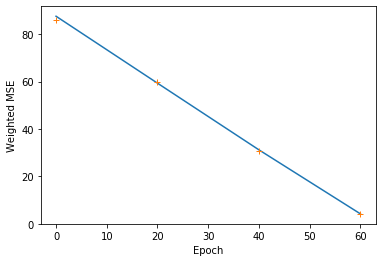

In [15]:
tl,vl = [],[]
lstm = LSTM(output_dim, len(feature_list), hidden_size, num_layers, seq_len)

# criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(x_train)
    optimizer.zero_grad()
    # obtain the loss function
    loss = weighted_MSELoss(outputs.unsqueeze(1), y_train,sc)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 20 == 0:
        print("*"*30)
        print("Epoch: %d, loss: %1.5f\n" % (epoch, loss.item()))
        tr, val = calculate_loss(lstm,x_train,y_train,x_val,y_val)
        tl.append(tr)
        vl.append(val)

# Print loss plot
plt.plot(20*np.arange(len(tl)-1),tl[1:])
plt.plot(20*np.arange(len(vl)-1),vl[1:],'+')
plt.xlabel("Epoch")
plt.ylabel("Weighted MSE")

#### 3) Evaluate the model

In [24]:
def print_results(x,y,lstm,sample_num):
    fontsize=12
    in_seq = sc.inverse_transform(x[sample_num])
    pred_norm = (lstm(x[sample_num].unsqueeze(0)).view(-1,3).detach())
    pred_point =     pred_norm*(sc.data_max_[:3]-sc.data_min_[:3])+sc.data_min_[:3]
    true_point = y[sample_num]*(sc.data_max_[:3]-sc.data_min_[:3])+sc.data_min_[:3]
    plt.figure(figsize=[20,4])
    plt.subplot(1,2,1)
    plt.plot(in_seq[:,0],in_seq[:,1],'x')
    plt.plot(pred_point[0,0],pred_point[0,1],'ro')
    plt.plot(true_point[0,0],true_point[0,1],'go')
    plt.xlabel("X",fontsize=fontsize)
    plt.ylabel("Y",fontsize=fontsize)
    
    plt.subplot(1,2,2)
    plt.plot(in_seq[:,0],in_seq[:,2],'x')
    plt.plot(pred_point[0,0],pred_point[0,2],'ro')
    plt.plot(true_point[0,0],true_point[0,2],'go')
    plt.xlabel("X",fontsize=fontsize)
    plt.ylabel("Z",fontsize=fontsize)
    plt.show()

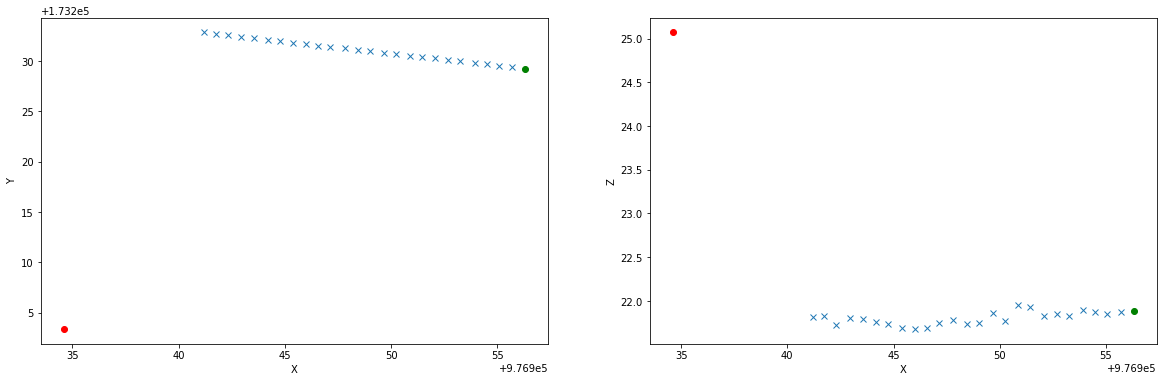

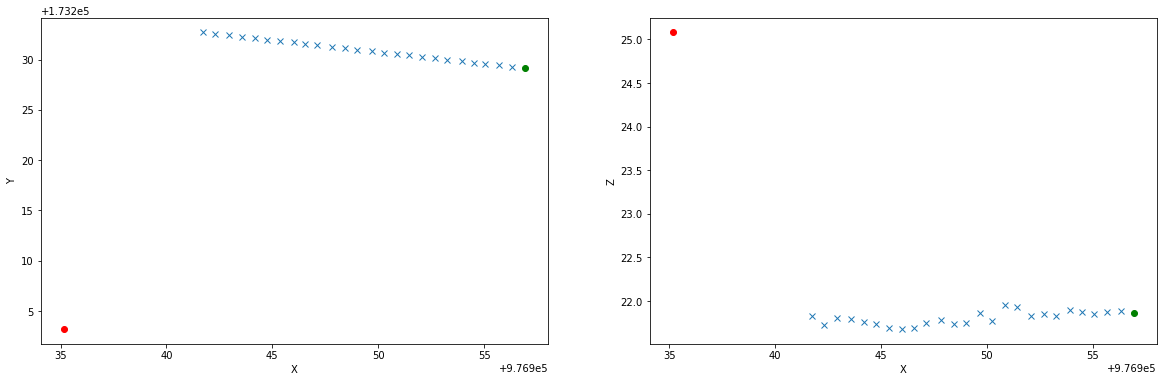

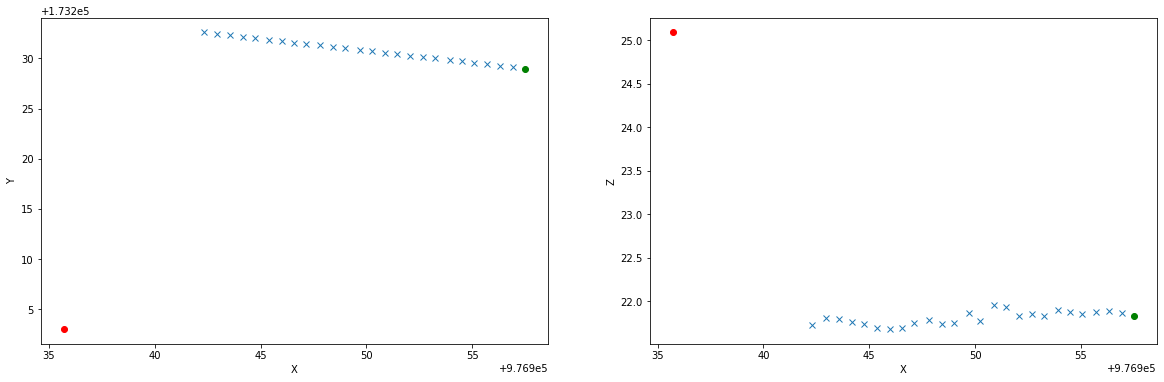

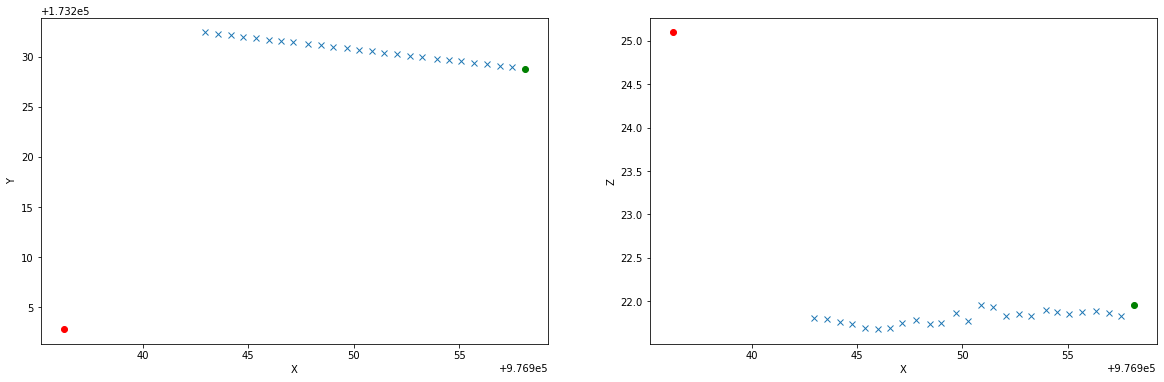

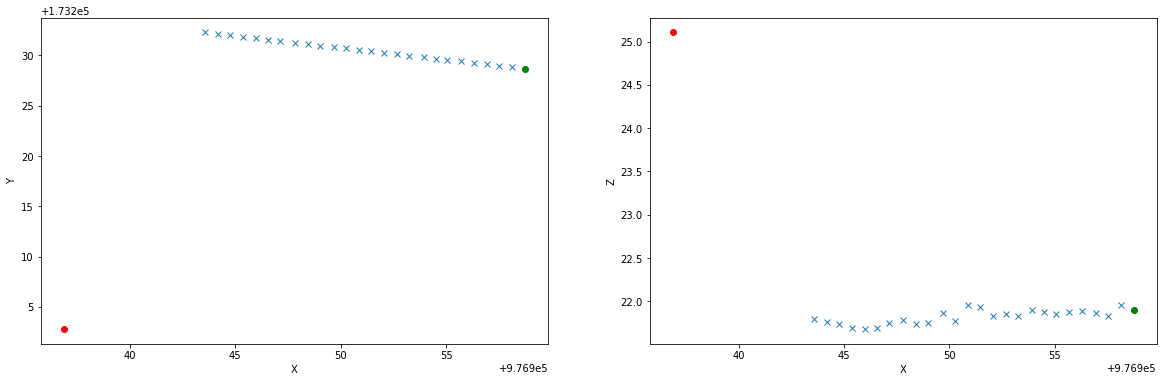

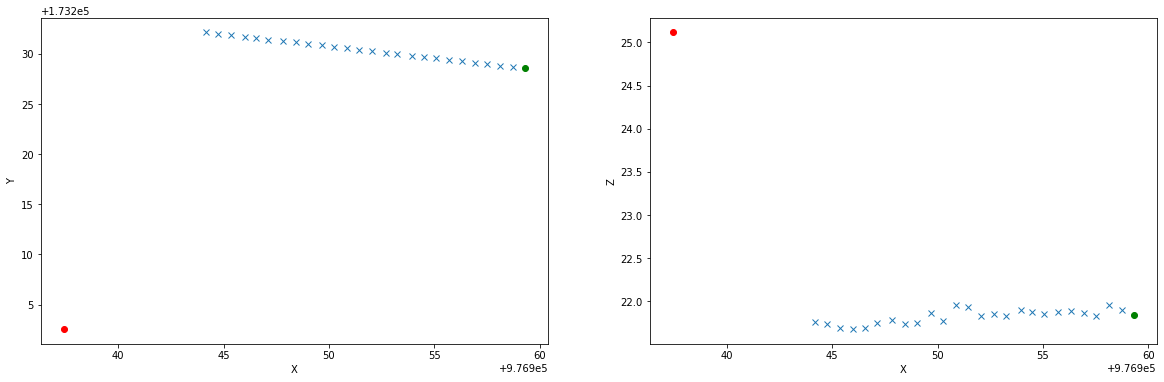

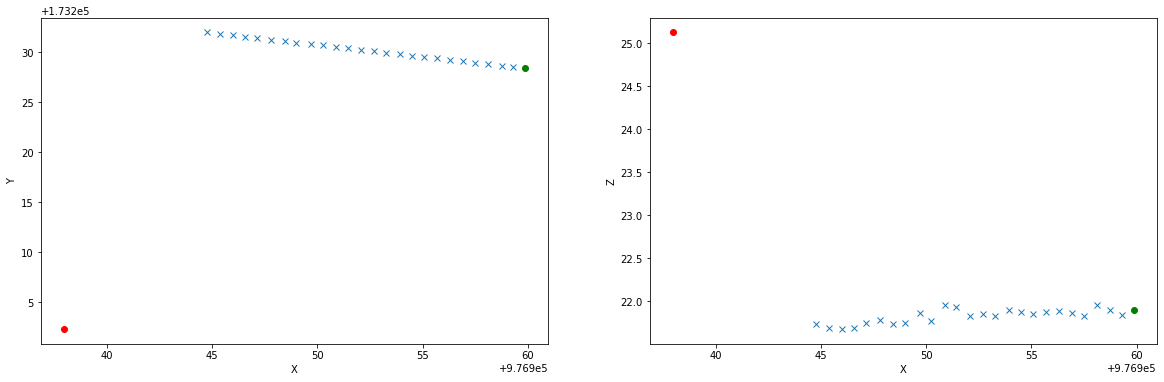

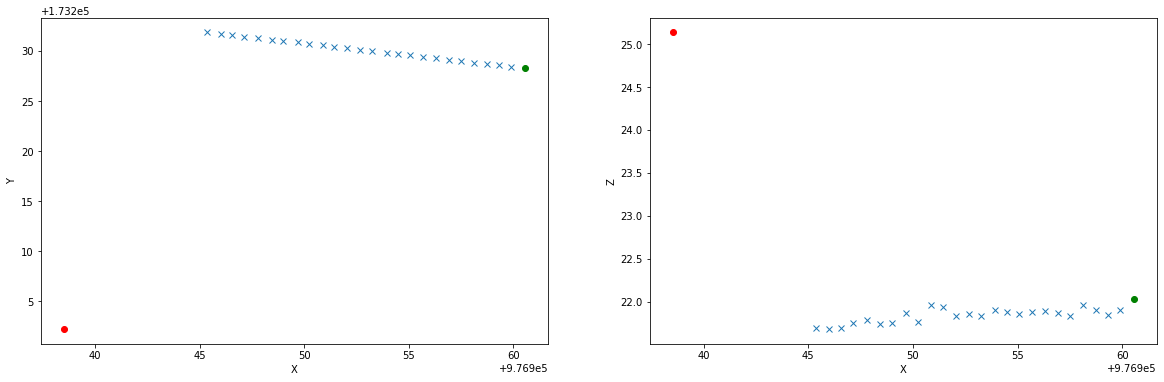

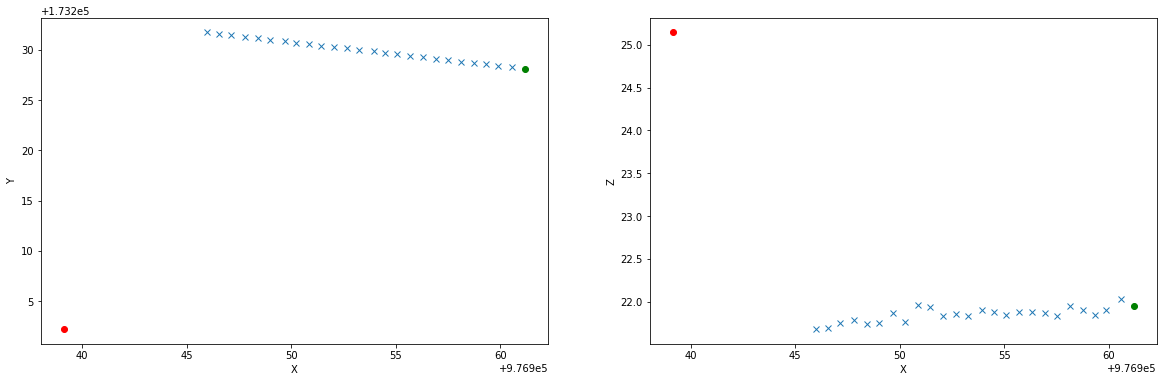

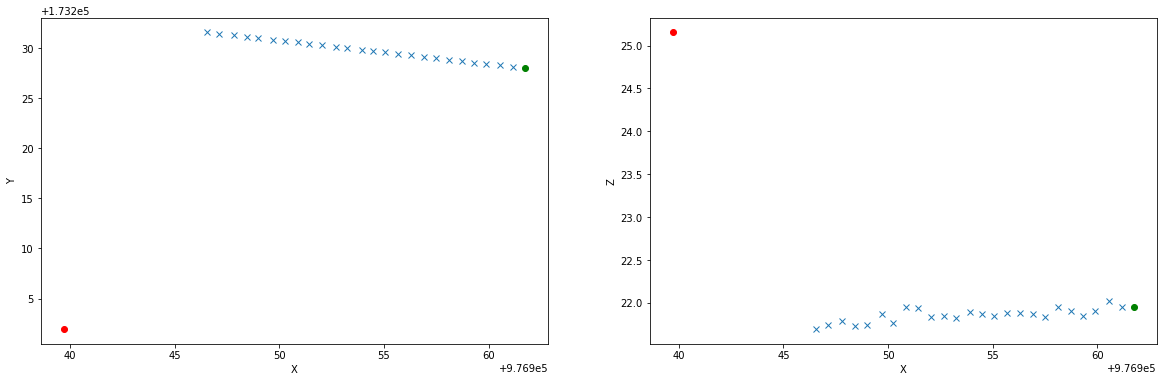

In [26]:
for i in range(2200,2210):
    print_results(x_train,y_train,lstm,i)

### Create .pts file of predictions
Include the actual and the predicted, indicated with a binary flag

In [74]:
def create_pts_file(y_val,x_val,lstm,sc):
    y_val_reinflate = np.concatenate((y_val[:,0,:]*(sc.data_max_[:3]-sc.data_min_[:3]) \
                                      +sc.data_min_[:3],np.zeros((y_val.shape[0],1))),axis=1)
    out_df = pd.DataFrame(np.array(y_val_reinflate[:,:]),columns=['x','y','z','class'])
    pred_norm = (lstm(x_val).view(-1,3).detach())
    pred_reinflate = pred_norm*(sc.data_max_[:3]-sc.data_min_[:3])+sc.data_min_[:3]
    pred_arr = np.concatenate((pred_reinflate,np.ones((pred_reinflate.shape[0],1))),axis=1)
    out_df = out_df.append(pd.DataFrame(pred_arr,columns = out_df.columns)).reset_index(drop=True)
    return out_df

In [75]:
out_df = create_pts_file(y_val,x_val,lstm,sc)
out_df.to_csv("output_test.pts")

In [73]:
out_df

,x,y,z,class
0,976583.312500,173303.359282,13.651000,0.0
1,976584.124999,173303.187579,13.609999,0.0
2,976584.812500,173303.015683,13.647001,0.0
3,976585.624999,173302.812568,13.639000,0.0
4,976586.375000,173302.656282,13.651000,0.0
...,...,...,...,...
16745,977565.751002,173150.847207,44.846813,1.0
16746,977565.972768,173150.804426,44.854068,1.0
16747,977566.197225,173150.768582,44.861399,1.0
16748,977566.414460,173150.708650,44.868871,1.0


### Data Prep
Already done, but this removes outliers and adds scan_line_idx to the first_return_df

In [ ]:
# Adj GPS Time: Set both timestamps to zero for the first record
def adjust_time(df,time_field):
    # Function adds adj_gps_time to points or pulse dataframe, set to zero at the minimum timestamp.
    df['adj_gps_time'] = df[time_field] - df[time_field].min()
    return df

def label_returns(las_df):
    '''
    Parses the flag_byte into number of returns and return number, adds these fields to las_df.
    Input - las_df - dataframe from .laz or .lz file
    Output - first_return_df - only the first return points from las_df.
           - las_df - input dataframe with num_returns and return_num fields added 
    '''
    
    las_df['num_returns'] = np.floor(las_df['flag_byte']/16).astype(int)
    las_df['return_num'] = las_df['flag_byte']%16
    first_return_df = las_df[las_df['return_num']==1]
    first_return_df = first_return_df.reset_index(drop=True)
    return first_return_df, las_df


def pull_first_scan_gap(df):
    # Separate return num, only keep the first returns, add scan_gap, sort
    df['num_returns'] = np.floor(df['flag_byte']/16).astype(int)
    df['return_num'] = df['flag_byte']%16
    
    first_return_wall = df[df['return_num']==1]
    
    # Outliers
    # Remove outliers outside of [.01,.99] percentiles
    a = first_return_wall[['x_scaled','y_scaled','z_scaled']].quantile([.01,.99])
    first_return_wall = first_return_wall[(first_return_wall['x_scaled']>a.iloc[0]['x_scaled'])&\
                                         (first_return_wall['x_scaled']<a.iloc[1]['x_scaled'])&\
                                         (first_return_wall['y_scaled']>a.iloc[0]['y_scaled'])&\
                                         (first_return_wall['y_scaled']<a.iloc[1]['y_scaled'])&\
                                         (first_return_wall['z_scaled']>a.iloc[0]['z_scaled'])&\
                                         (first_return_wall['z_scaled']<a.iloc[1]['z_scaled'])]
    
    first_return_wall.sort_values(by=['gps_time'],inplace=True)
    first_return_wall.reset_index(inplace=True)
    first_return_wall.loc[1:,'scan_gap'] = [first_return_wall.loc[i+1,'scan_angle'] - first_return_wall.loc[i,'scan_angle'] for i in range(first_return_wall.shape[0]-1)]
    first_return_wall.loc[0,'scan_gap'] = 0
    first_return_wall['scan_angle_deg'] = first_return_wall['scan_angle']*.006
    return first_return_wall

# Load LAS points
las_df = pd.read_hdf("../../Data/parking_lot/las_points_164239.lz")
# Separate out the first returns only
las_df = adjust_time(las_df,'gps_time')
# Sort records by timestamp
las_df.sort_values(by=['adj_gps_time'],inplace=True)
# TO DO: consider only last returns?
# First returns only
first_return_df = pull_first_scan_gap(las_df)

In [ ]:


# Save the scaler
dump(lstm, open('models/lstm_unidirectional_model_1000epochs_25scan_lines_8_25_20.pkl','wb'))
# dump(sc, open('models/SCALER.pkl', 'wb'))

In [ ]:
# # Identify the indices for points at end of scan lines
scan_break_idx = first_return_df[(first_return_df['scan_gap']>scan_line_gap_break)].index

# # Concat adds index 0 as 0th scan line
_right = pd.DataFrame(data=range(1,len(scan_break_idx)+1),index=scan_break_idx,columns=['scan_line_idx'])
right = pd.concat([pd.DataFrame(data=[0],index=[0],columns=['scan_line_idx']),_right])
first_return_df = pd.merge_asof(first_return_df,right,left_index=True,right_index=True,direction='backward')